In [1]:
import numpy as np
from numba import cuda
from time import time
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
def Pi_CPU(pi_size, N):
    res = np.zeros(pi_size)
    for i in range(pi_size):
        x = np.random.rand(N)
        y = np.random.rand(N)
        z = x ** 2 + y ** 2 <= 1
        res[i] = 4.0 * sum(z) / N
    return res.mean()

In [37]:
@cuda.jit
def Pi_calcul(res, rng):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    h = 0
    if i < len(rng):
        x = xoroshiro128p_uniform_float32(rng, i)
        y = xoroshiro128p_uniform_float32(rng, i)
        if x ** 2 + y ** 2 <= 1.0:
            h += 1
    cuda.atomic.add(res, 0, h)

In [39]:
def Pi_GPU(N):
    rng = create_xoroshiro128p_states(N, seed=1)
    res = np.zeros(1)

    dev_res = cuda.to_device(res)
    Pi_calcul[N, TPB](dev_res, rng)
    tmp_ = dev_res.copy_to_host()
    pi_ = 4 * tmp_[0] / N
    return pi_

In [62]:
TPB = 16
pi_size = 64
BPG = int(pi_size / TPB)
N = 10000
N_mass = []
boost_mass = []
file = open("text.txt", "w")
for i in range(10):
    cpu_start = time()
    cpu_pi = Pi_CPU(pi_size, N)
    cpu_time = time() - cpu_start

    gpu_start = time()
    gpu_pi = Pi_GPU(N)
    gpu_time = time() - gpu_start
    
    file.write((f'gpu time: {gpu_time} c\n'))
    file.write((f'cpu time: {cpu_time} c\n'))
    file.write((f'Pi with GPU: {gpu_pi}\n'))
    file.write((f'Pi with CPU: {cpu_pi}\n'))
    file.write((f'gpu vs cpu (Pi): {abs(gpu_pi-cpu_pi)}\n'))
    file.write((f'gpu vs cpu (time): {cpu_time/gpu_time} раз\n'))
    file.write((f'Кол-во точек: {N}\n'))
    boost_mass.append(cpu_time/gpu_time)
    N_mass.append(N)
    N += 10000
file.close()

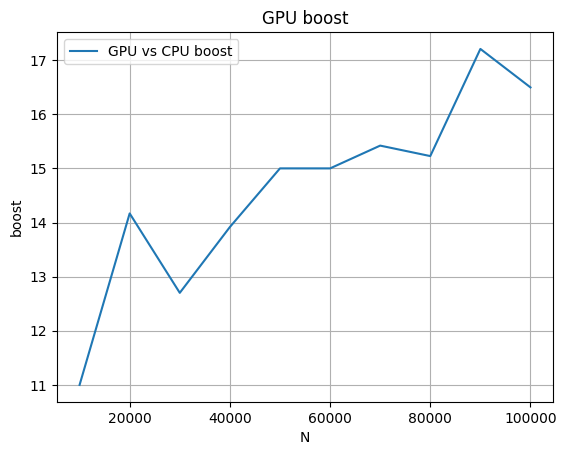

In [61]:
plt.plot(N_mass, boost_mass, label='GPU vs CPU boost')
plt.title('GPU boost')
plt.xlabel('N')
plt.ylabel('boost')
plt.legend()
plt.grid()
plt.show()